In [42]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

In [43]:
# hyperparameter setting
mb_size = 32
X_dim = 784
z_dim = 64
h_dim = 128
lr = 1e-3
m = 5
lam = 1e-3
gamma = 0.5  
k_curr = 0

In [44]:
# Load MNIST datasets
mnist = input_data.read_data_sets('data/mnist', one_hot=True)

Extracting data/mnist/train-images-idx3-ubyte.gz
Extracting data/mnist/train-labels-idx1-ubyte.gz
Extracting data/mnist/t10k-images-idx3-ubyte.gz
Extracting data/mnist/t10k-labels-idx1-ubyte.gz


In [45]:
#visualization
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

In [46]:
# xavier initialization
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [47]:
# Define placeholder
X = tf.placeholder(tf.float32, shape=[None, X_dim]) # MNIST RealImage = 28*28
z = tf.placeholder(tf.float32, shape=[None, z_dim]) # Noise Dimension = 64
k = tf.placeholder(tf.float32)

In [48]:
# ********* Generator-Network 
# Hidden Layer parameter - weights & biases
G_W1 = tf.Variable(xavier_init([z_dim, h_dim])) # h_dim (Hidden Node) = 128 , z_dim = noise vector
G_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

# Output Layer parameter - weights & biases
G_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
G_b2 = tf.Variable(tf.zeros(shape=[X_dim]))

# Generator

def G(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)
    return G_prob

In [49]:
# ********* Discriminator-Network 
# Hidden Layer parameter - weights & biases
D_W1 = tf.Variable(xavier_init([X_dim, h_dim]))
D_b1 = tf.Variable(tf.zeros(shape=[h_dim]))
# Output Layer parameter - weights & biases
D_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
D_b2 = tf.Variable(tf.zeros(shape=[X_dim]))

# Discriminator

def D(X):
    D_h1 = tf.nn.relu(tf.matmul(X, D_W1) + D_b1)
    X_recon = tf.matmul(D_h1, D_W2) + D_b2
    return tf.reduce_mean(tf.reduce_sum((X - X_recon)**2, 1))

In [50]:
# make noise-Latent Variable의 input으로 사용할 noise를 Uniform Distribution에서 batch_size만큼 샘플링
def sample_z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])  # m = Test Sample Size, n = Noise Dimension

In [51]:
# ********* Generation, Loss, Optimization and Session Init.
G_sample = G(z)

D_real = D(X)
D_fake = D(G_sample)
# Discriminator의 loss function
D_loss = D_real - k*D_fake
# Generator의 loss function
G_loss = D_fake

# Discriminator와 Generator의 Optimizer
optim_D = (tf.train.AdamOptimizer(learning_rate=lr)
            .minimize(D_loss, var_list=[D_W1, D_W2, D_b1, D_b2]))
optim_G = (tf.train.AdamOptimizer(learning_rate=lr)
            .minimize(G_loss, var_list=[G_W1, G_W2, G_b1, G_b2]))

sess = tf.Session()
sess.run(tf.global_variables_initializer())

Iter-0; Convergence measure: 589.9


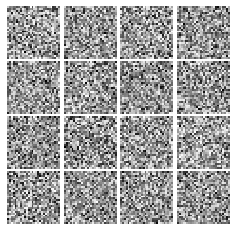

Iter-1000; Convergence measure: 29.75


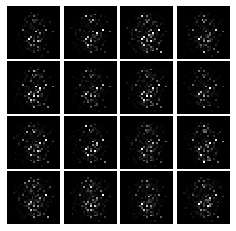

Iter-2000; Convergence measure: 37.95


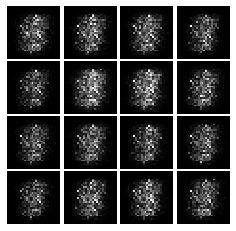

Iter-3000; Convergence measure: 32.41


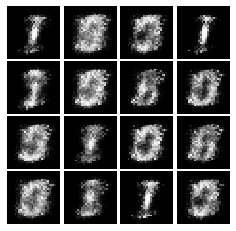

Iter-4000; Convergence measure: 26.57


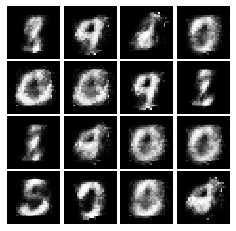

Iter-5000; Convergence measure: 28.33


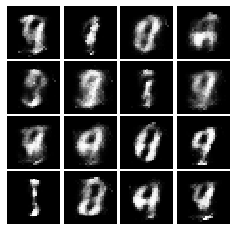

Iter-6000; Convergence measure: 25.3


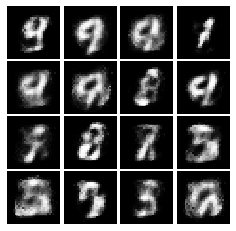

Iter-7000; Convergence measure: 22.47


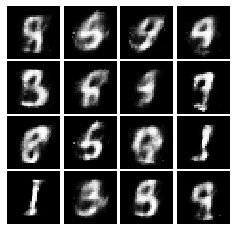

Iter-8000; Convergence measure: 23.55


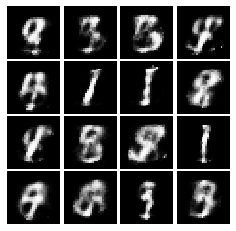

In [ ]:
# ********* Training and Testing

if not os.path.exists('out/'):
    os.makedirs('out/')  # make outputs folder

i = 0
num_epoch = 10000

for epoch in range(num_epoch): # 10000 = Num. of Epoch
    # load MNIST images
    batch_xs, _ = mnist.train.next_batch(mb_size) # mb_size = Batch Size
    
    _, D_real_curr = sess.run(
        [optim_D, D_real],
        feed_dict={X: batch_xs, z: sample_z(mb_size, z_dim), k: k_curr}
    )

    _, D_fake_curr = sess.run(
        [optim_G, D_fake],
        feed_dict={X: batch_xs, z: sample_z(mb_size, z_dim)}
    )
    Image("img/form2.png") 
    k_curr = k_curr + lam * (gamma*D_real_curr - D_fake_curr)   
#   print('Epoch:', '%04d' % epoch,'D loss: {:.4}'.format(D_real_curr),'G loss: {:.4}'.format(D_fake_curr))
    if epoch % 1000 == 0: # 10 = Saving period
        # convergence measure
        measure = D_real_curr + np.abs(gamma*D_real_curr - D_fake_curr)
        print('Iter-{}; Convergence measure: {:.4}' .format(epoch, measure))
      
        samples = sess.run(G_sample, feed_dict={z: sample_z(16, z_dim)})
        fig = plot(samples)
        plt.savefig('out/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')                
        plt.show()
        i += 1
        plt.close(fig)
           